In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from glob import glob
import MDAnalysis as mda
from MDAnalysis.analysis import distances
import warnings
warnings.filterwarnings('ignore')
import scipy.sparse
from natsort import natsorted
from MDAnalysis.lib.distances import (
           capped_distance,
           self_distance_array, distance_array,  # legacy reasons
)
from MDAnalysis.lib.c_distances import contact_matrix_no_pbc, contact_matrix_pbc
from MDAnalysis.lib.NeighborSearch import AtomNeighborSearch
from MDAnalysis.lib.distances import calc_bonds
import logging
logger = logging.getLogger("MDAnalysis.analysis.distances")
import os, subprocess
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from rdkit.Chem import DataStructs,AllChem
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
from IPython import embed as e
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import CalcNumAromaticRings
from rdkit.Chem.rdMolDescriptors import CalcNumAromaticHeterocycles
from rdkit.Chem.rdMolDescriptors import CalcNumAtoms
import seaborn as sns

/home/juan/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/juan/myenv/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [59]:
import os
import pandas as pd
from collections import defaultdict

def parse_pdb_atom_data(pdb_file_path):
    atoms = []
    with open(pdb_file_path, 'r') as file:
        for line in file:
            if line.startswith("ATOM"):
                parts = line.split()
                atom_type = parts[2][0]  # First letter -> Element
                #charge = parts[11]
                x = float(parts[6])
                y = float(parts[7])
                z = float(parts[8])
                atoms.append((atom_type, x, y, z))
    return atoms

def process_pdb_folder(folder_path):
    pdb_data = defaultdict(list) 
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".pdbqt"):
            full_path = os.path.join(folder_path, file_name)
            atoms = parse_pdb_atom_data(full_path)
            pdb_data[file_name] = atoms
    return pdb_data

folder_path = '/home/juan/Documents/Master_Project/experiments/test_pdbqt'
pdb_folder_data = process_pdb_folder(folder_path)


def dict_to_dataframe(pdb_data):
    rows = []
    for file_name, atoms in pdb_data.items():
        for atom in atoms:
            rows.append([file_name, *atom])  # Unpack atom tuple and prepend file name
    columns = ['File Name', 'Atom Type', 'X', 'Y', 'Z']
    return pd.DataFrame(rows, columns=columns)

# Convert to DataFrame
pdb_data_df = dict_to_dataframe(pdb_folder_data)


In [60]:
pdb_data_df

,File Name,Atom Type,X,Y,Z
0,mol_62.pdbqt,C,-6.247,0.679,1.855
1,mol_62.pdbqt,N,-5.720,-0.519,1.463
2,mol_62.pdbqt,C,-5.698,-0.868,0.151
3,mol_62.pdbqt,C,-6.225,-0.040,-0.841
4,mol_62.pdbqt,C,-6.802,1.167,-0.459
...,...,...,...,...,...
232,mol_45.pdbqt,N,-4.225,-5.826,6.643
233,mol_45.pdbqt,C,-5.285,-6.646,7.410
234,mol_45.pdbqt,H,-3.801,-6.415,5.940
235,mol_45.pdbqt,C,-5.916,-4.992,4.876


PDBQT

In [4]:
import os
import pandas as pd

def parse_pdbqt_atom_data(pdbqt_file_path):
    atoms = []
    with open(pdbqt_file_path, 'r') as file:
        for line in file:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                parts = line.split()
                atom_type = parts[2][0]  # Simplifying to first letter might not always be accurate for pdbqt
                x = float(parts[6])  # Adjusted indices for pdbqt format
                y = float(parts[7])
                z = float(parts[8])
                charge = float(parts[11])  # Charge is the last column in pdbqt
                atoms.append((atom_type, x, y, z, charge))
    return atoms

def parse_psf_charge_data(psf_file_path):
    charges = defaultdict(float)  # Use defaultdict to handle missing atoms gracefully
    parsing_atoms = False
    with open(psf_file_path, 'r') as file:
        for line in file:
            if "!NATOM" in line:
                parsing_atoms = True
                continue
            
            if parsing_atoms:
                if line.strip().isdigit() or not line.strip():
                    parsing_atoms = False  # Stop parsing if only digits or empty line, indicating end of atom section
                    continue
                
                parts = re.findall(r'\S+', line)
                if len(parts) >= 6:
                    atom_id = int(parts[0])  # Unique atom identifier
                    atom_name = parts[4]  
                    charge = float(parts[6])
                    charges[atom_id] = (atom_name, charge)  
    return charges

def process_pdbqt_folder(folder_path):
    pdbqt_data = defaultdict(list)
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".pdbqt"):
            full_path = os.path.join(folder_path, file_name)
            atoms = parse_pdbqt_atom_data(full_path)
            pdbqt_data[file_name] = atoms
    return pdbqt_data

folder_path = '/home/juan/Documents/Master_Project/data/raw/correct_pdbqt'
pdbqt_folder_data = process_pdbqt_folder(folder_path)

def dict_to_dataframe(pdbqt_data):
    rows = []
    for file_name, atoms in pdbqt_data.items():
        for atom in atoms:
            # Now also includes charge in the output
            rows.append([file_name, *atom])  # Unpack atom tuple and prepend file name
    columns = ['File Name', 'Atom Type', 'X', 'Y', 'Z', 'Charge']
    return pd.DataFrame(rows, columns=columns)

# Convert to DataFrame
pdbqt_data_df = dict_to_dataframe(pdbqt_folder_data)


## Function givne folder of pdb or pdbqt and psf

In [1]:
import re
import os
import pandas as pd
from collections import defaultdict

def parse_psf_charge_data(psf_file_path):
    charges = defaultdict(float)  # Use defaultdict to handle missing atoms gracefully
    parsing_atoms = False
    with open(psf_file_path, 'r') as file:
        for line in file:
            # Check for the start of the atom section based on the file format
            if "!NATOM" in line:
                parsing_atoms = True
                continue
            
            if parsing_atoms:
                if line.strip().isdigit() or not line.strip():
                    parsing_atoms = False  
                    continue
                
                parts = re.findall(r'\S+', line)
                if len(parts) >= 6:
                    atom_id = int(parts[0]) 
                    atom_name = parts[4]  
                    charge = float(parts[6])
                    charges[atom_id] = (atom_name, charge)  
    return charges

def parse_pdbqt_atom_data(pdbqt_file_path):
    atoms = []
    with open(pdbqt_file_path, 'r') as file:
        for line in file:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                parts = line.split()
                atom_type = parts[2][0]  
                x = float(parts[6]) 
                y = float(parts[7])
                z = float(parts[8])
                atoms.append((atom_type, x, y, z))
    return atoms


def process_files(pdbqt_folder_path, psf_folder_path):
    combined_data = defaultdict(list)
    
    pdb_files = [file for file in os.listdir(pdbqt_folder_path) if file.endswith(".pdb")]
    psf_files = [file for file in os.listdir(psf_folder_path) if file.endswith(".psf")]

    for pdbqt_file in pdb_files:
        base_name = os.path.splitext(pdbqt_file)[0]  # Extract base name without extension
        psf_file_name = base_name + "_new.psf"  # Construct PSF file name based on PDBQT file name
        
        if psf_file_name in psf_files:
            pdbqt_path = os.path.join(pdbqt_folder_path, pdbqt_file)
            psf_path = os.path.join(psf_folder_path, psf_file_name)
            
            pdbqt_atoms = parse_pdbqt_atom_data(pdbqt_path)
            psf_charges = parse_psf_charge_data(psf_path)

            for atom_index, atom in enumerate(pdbqt_atoms, start=1):  # Starting index from 1 to match PSF IDs
                atom_type, x, y, z = atom
                psf_data = psf_charges.get(atom_index, ("Unknown", 0.0))  # Get PSF charge data by atom index
                _, charge = psf_data 

                combined_data['File Name'].append(pdbqt_file)
                combined_data['Atom Type'].append(atom_type)
                combined_data['X'].append(x)
                combined_data['Y'].append(y)
                combined_data['Z'].append(z)
                combined_data['Charge'].append(charge)

    return pd.DataFrame(combined_data)

folder_path1 = '/home/juan/Documents/Master_Project/data/raw/correct_pdb_ext'
folder_path2 = '/home/juan/Documents/Master_Project/psf_files_copy (copy)'
df = process_files(folder_path1, folder_path2)


{(0, 0, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa321d0>,
 (0, 0, 4): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa22f50>,
 (0, 1, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa40dd0>,
 (0, 1, 4): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa428d0>,
 (0, 2, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa43fd0>,
 (0, 2, 4): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa49810>,
 (0, 3, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa4ab10>,
 (0, 3, 4): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa4bd10>,
 (0, 4, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa55450>,
 (0, 4, 4): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa56bd0>,
 (1, 0, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa5c410>,
 (1, 0, 4): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa5da10>,
 (1, 1, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x78667aa5eed0>,

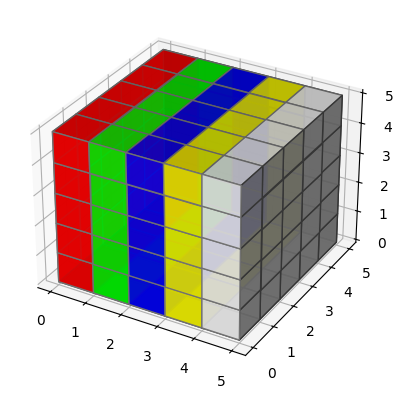

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
 
 
axes = [5, 5, 5]
 
data = np.ones(axes)
 
alpha = 0.9
 
# Colour
colors = np.empty(axes + [4], dtype=np.float32)
 
colors[0] = [1, 0, 0, alpha] 
colors[1] = [0, 1, 0, alpha]
colors[2] = [0, 0, 1, alpha] 
colors[3] = [1, 1, 0, alpha]  
colors[4] = [1, 1, 1, alpha]  
 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
 
# Voxels is used to customizations of
# the sizes, positions and colors.
ax.voxels(data, facecolors=colors, edgecolors='grey')

In [11]:
# Box Dimension
box_x_updated = 6  

# Ranges
x_range_updated = 6 - (-18)  
y_range_updated = 19 - (-11) 
z_range_updated = 13 - (-11) 

num_boxes_x_updated_again = x_range_updated // box_x_updated
num_boxes_y_updated_new = y_range_updated // box_x_updated
num_boxes_z_updated_new = z_range_updated // box_x_updated

total_boxes_updated_again = num_boxes_x_updated_again * num_boxes_y_updated_new * num_boxes_z_updated_new

def box_coverage(num_boxes_x, num_boxes_y, num_boxes_z, box_x, box_y, box_z, start_x=-18, start_y=-11, start_z=-11):
    boxes = []
    for z in range(num_boxes_z):
        for y in range(num_boxes_y):
            for x in range(num_boxes_x):
                box_start_x = start_x + x * box_x
                box_end_x = box_start_x + box_x
                box_start_y = start_y + y * box_y
                box_end_y = box_start_y + box_y
                box_start_z = start_z + z * box_z
                box_end_z = box_start_z + box_z
                boxes.append({
                    "box_number": len(boxes) + 1,
                    "x_range": (box_start_x, box_end_x),
                    "y_range": (box_start_y, box_end_y),
                    "z_range": (box_start_z, box_end_z),
                })
    return boxes

box_list = box_coverage(num_boxes_x_updated_again, num_boxes_y_updated_new, num_boxes_z_updated_new, box_x_updated, box_x_updated, box_x_updated)

total_boxes_updated_again, box_list[:5] 


(80,
 [{'box_number': 1,
   'x_range': (-18, -12),
   'y_range': (-11, -5),
   'z_range': (-11, -5)},
  {'box_number': 2,
   'x_range': (-12, -6),
   'y_range': (-11, -5),
   'z_range': (-11, -5)},
  {'box_number': 3,
   'x_range': (-6, 0),
   'y_range': (-11, -5),
   'z_range': (-11, -5)},
  {'box_number': 4,
   'x_range': (0, 6),
   'y_range': (-11, -5),
   'z_range': (-11, -5)},
  {'box_number': 5,
   'x_range': (-18, -12),
   'y_range': (-5, 1),
   'z_range': (-11, -5)}])

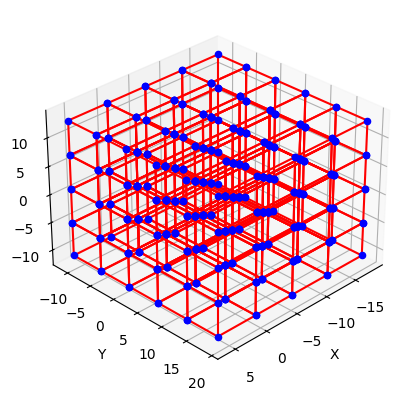

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for box in box_list:
    x_range = box['x_range']
    y_range = box['y_range']
    z_range = box['z_range']
    
    for dx in [0, 1]:
        for dy in [0, 1]:
            for dz in [0, 1]:
                x = x_range[dx]
                y = y_range[dy]
                z = z_range[dz]
                ax.scatter(x, y, z, color='b') 
    
    edges = [(0, 1), (1, 3), (3, 2), (2, 0),  
             (4, 5), (5, 7), (7, 6), (6, 4),  
             (0, 4), (1, 5), (3, 7), (2, 6)]  
    
    corners = [(x_range[0], y_range[0], z_range[0]), (x_range[1], y_range[0], z_range[0]),
               (x_range[0], y_range[1], z_range[0]), (x_range[1], y_range[1], z_range[0]),
               (x_range[0], y_range[0], z_range[1]), (x_range[1], y_range[0], z_range[1]),
               (x_range[0], y_range[1], z_range[1]), (x_range[1], y_range[1], z_range[1])]
    
    for edge in edges:
        start, end = edge
        ax.plot([corners[start][0], corners[end][0]],
                [corners[start][1], corners[end][1]],
                [corners[start][2], corners[end][2]], 'r')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(30, 45)

plt.show()


In [13]:
def check_for_overlaps(boxes):
    def ranges_overlap(a, b):
        return a[0] < b[1] and b[0] < a[1]
    
    for i, box_a in enumerate(boxes):
        for j, box_b in enumerate(boxes):
            if i != j:
                if ranges_overlap(box_a['x_range'], box_b['x_range']) and \
                   ranges_overlap(box_a['y_range'], box_b['y_range']) and \
                   ranges_overlap(box_a['z_range'], box_b['z_range']):
                    return True, (box_a['box_number'], box_b['box_number'])
    return False, None

has_overlap, overlapping_boxes = check_for_overlaps(box_list)
has_overlap, overlapping_boxes


(False, None)

In [15]:
from collections import defaultdict

def assign_atoms_to_boxes_for_df(df, box_list):
    file_box_charges = defaultdict(lambda: {box['box_number']: 0.0 for box in box_list})

    def find_box_for_atom(x, y, z, box_list):
        for box in box_list:
            if box['x_range'][0] <= x < box['x_range'][1] and \
               box['y_range'][0] <= y < box['y_range'][1] and \
               box['z_range'][0] <= z < box['z_range'][1]:
                return box['box_number']
        return None

    for atom in df.itertuples(index=False):
        file_name = atom._0
        x, y, z, charge = atom.X, atom.Y, atom.Z, atom.Charge
        box_number = find_box_for_atom(x, y, z, box_list)

        if box_number is not None:
            file_box_charges[file_name][box_number] += charge

    return dict(file_box_charges)

box_charge = assign_atoms_to_boxes_for_df(df, box_list)


In [16]:
import pandas as pd

def convert_box_charge_to_df(box_charge):
    rows_list = []

    for file_name, charges in box_charge.items():
        # Start building a row with file name
        row = {'File Name': file_name}
        # Add charges for each box to the row
        for box_number, charge in charges.items():
            row[f'Box_{box_number}'] = charge
        # Append the row to the list
        rows_list.append(row)
    
    # Create the DataFrame
    df = pd.DataFrame(rows_list)
    
    expected_boxes = [f'Box_{i}' for i in range(1, 81)]
    for box in expected_boxes:
        if box not in df:
            df[box] = 0.0
    
    df = df[['File Name'] + expected_boxes]
    
    return df

# Using the 'box_charge' dictionary to create the DataFrame
df_box_charges = convert_box_charge_to_df(box_charge)

print(df_box_charges.head())


        File Name  Box_1  Box_2  Box_3  Box_4  Box_5  Box_6  Box_7  Box_8  \
0  mol_134810.pdb    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1  mol_147462.pdb    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2   mol_22419.pdb    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3     mol_469.pdb    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4   mol_67286.pdb    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   Box_9  ...  Box_71  Box_72  Box_73  Box_74  Box_75  Box_76  Box_77  Box_78  \
0    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Box_79  Box_80  
0     0.0     0.0  
1     0.0 

In [17]:
df_box_charges.to_csv('/home/juan/Documents/Master_Project/data/interim/box_data_updated.csv')

In [ ]:
def filter_non_empty_boxes_with_charge(file_box_atoms):
    non_empty_boxes_by_file = {}

    for file_name, boxes in file_box_atoms.items():
        non_empty_boxes = {}
        for box_number, box_data in boxes.items():
            atom_counts = box_data['atom_counts']
            total_charge = box_data['total_charge']
            # Check if the box is non-empty by atom count or total charge
            if any(count > 0 for count in atom_counts.values()) or total_charge != 0.0:
                non_empty_boxes[box_number] = box_data
        if non_empty_boxes:
            non_empty_boxes_by_file[file_name] = non_empty_boxes

    return non_empty_boxes_by_file

non_empty_boxes_with_charge = filter_non_empty_boxes_with_charge(box_charge)


file_name_to_check = 'mol_150525.pdbqt'
if file_name_to_check in non_empty_boxes_with_charge:
    for box, data in non_empty_boxes_with_charge[file_name_to_check].items():
        print(f"Box {box}: Atom Counts: {data['atom_counts']}, Total Charge: {data['total_charge']}")
else:
    print(f"No non-empty boxes found for {file_name_to_check}.")


Box 26: Atom Counts: defaultdict(<class 'int'>, {'N': 1, 'C': 1, 'O': 1, 'H': 0, 'F': 0, 'B': 0, 'S': 0}), Total Charge: -0.40800000000000003
Box 27: Atom Counts: defaultdict(<class 'int'>, {'C': 4, 'H': 0, 'F': 0, 'O': 0, 'B': 0, 'N': 0, 'S': 0}), Total Charge: 0.397
Box 30: Atom Counts: defaultdict(<class 'int'>, {'C': 3, 'H': 0, 'F': 0, 'O': 0, 'B': 0, 'N': 0, 'S': 0}), Total Charge: 0.272
Box 31: Atom Counts: defaultdict(<class 'int'>, {'H': 1, 'N': 1, 'C': 5, 'O': 1, 'F': 0, 'B': 0, 'S': 0}), Total Charge: -0.09999999999999998
Box 46: Atom Counts: defaultdict(<class 'int'>, {'H': 1, 'F': 0, 'O': 0, 'B': 0, 'N': 0, 'S': 0, 'C': 0}), Total Charge: 0.279
Box 47: Atom Counts: defaultdict(<class 'int'>, {'N': 1, 'C': 2, 'H': 0, 'F': 0, 'O': 0, 'B': 0, 'S': 0}), Total Charge: 0.435
Box 51: Atom Counts: defaultdict(<class 'int'>, {'H': 1, 'C': 3, 'O': 1, 'F': 0, 'B': 0, 'N': 0, 'S': 0}), Total Charge: 0.127


In [ ]:
import pandas as pd

def create_charge_dataframe(non_empty_boxes_with_charge):
    molecule_charge_data = {}
    
    box_columns = [f'box_{i}' for i in range(1, 81)]
    for file_name, boxes in non_empty_boxes_with_charge.items():
        mol_name = file_name.strip('.pdbqt')
        charge_data = [0.0] * 80  # Start with all zeros for 80 boxes
        for box_number, box_data in boxes.items():
            # Update the charge for the specific box, -1 because box_number starts from 1 but index from 0
            charge_data[box_number - 1] = box_data['total_charge']
        molecule_charge_data[mol_name] = charge_data
    
    # Create the DataFrame
    df = pd.DataFrame.from_dict(molecule_charge_data, orient='index', columns=box_columns)
    df.index.name = 'Folder'
    df.reset_index(inplace=True)
    
    return df

charge_df = create_charge_dataframe(box_charge)


charge_df.head()

,Folder,box_1,box_2,box_3,box_4,box_5,box_6,box_7,box_8,box_9,...,box_71,box_72,box_73,box_74,box_75,box_76,box_77,box_78,box_79,box_80
0,mol_150525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,mol_106877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,mol_34890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,mol_64934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,mol_34080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
